In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import math
import datetime as dt

from arch import arch_model

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_error, mean_squared_error

import os
from eodhd import APIClient
import requests
from datetime import datetime

Observe volatility clustering

Volatility clustering is frequently observed in financial market data, and it poses a challenge for time series modeling.

In this exercise, you will get familiar with the S&P 500 daily price dataset. You will calculate daily returns as the percentage price changes, plot the results and observe its behavior over time.

In [2]:
SP500 = pd.read_csv('SP500.csv', index_col='Date')
SP500.index = pd.to_datetime(SP500.index)
SP500

,Close,Return
Date,,
2010-07-01,1027.37000000,-0.32404847
2010-07-02,1022.58000000,-0.46623904
2010-07-06,1028.06000000,0.53589939
2010-07-07,1060.27000000,3.13308562
2010-07-08,1070.24000000,0.94032652
...,...,...
2019-10-04,2952.01000000,1.42168534
2019-10-07,2938.79000000,-0.44783046
2019-10-08,2893.06000000,-1.55608261


In [3]:
sp_price = SP500[['Close']]
sp_price

,Close
Date,
2010-07-01,1027.37000000
2010-07-02,1022.58000000
2010-07-06,1028.06000000
2010-07-07,1060.27000000
2010-07-08,1070.24000000
...,...
2019-10-04,2952.01000000
2019-10-07,2938.79000000
2019-10-08,2893.06000000


In [4]:
# Calculate daily returns as percentage price changes
sp_price['Return'] = 100 * (sp_price['Close'].pct_change())
sp_price

,Close,Return
Date,,
2010-07-01,1027.37000000,NaN
2010-07-02,1022.58000000,-0.46623904
2010-07-06,1028.06000000,0.53589939
2010-07-07,1060.27000000,3.13308562
2010-07-08,1070.24000000,0.94032652
...,...,...
2019-10-04,2952.01000000,1.42168534
2019-10-07,2938.79000000,-0.44783046
2019-10-08,2893.06000000,-1.55608261


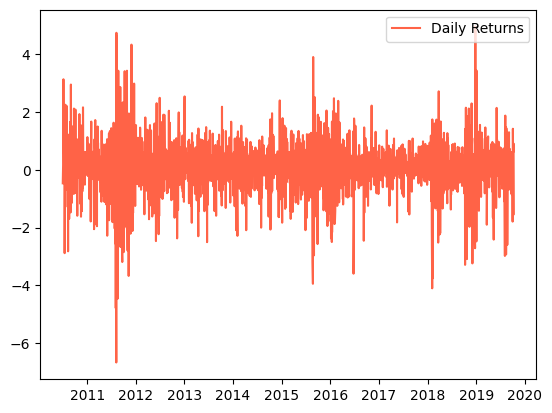

In [5]:
# plot the data
plt.plot(sp_price['Return'], color = 'tomato', label = 'Daily Returns')
plt.legend(loc='upper right')
plt.show()

Calculate volatility

In this exercise, you will practice how to compute and convert volatility of price returns in Python.

Firstly, you will compute the daily volatility as the standard deviation of price returns. Then convert the daily volatility to monthly and annual volatility.

In [6]:
sp_data = sp_price.loc['2017-10-16':'2019-10-10']
sp_data

,Close,Return
Date,,
2017-10-16,2557.64000000,0.17507647
2017-10-17,2559.36000000,0.06724950
2017-10-18,2561.26000000,0.07423731
2017-10-19,2562.10000000,0.03279636
2017-10-20,2575.21000000,0.51168963
...,...,...
2019-10-04,2952.01000000,1.42168534
2019-10-07,2938.79000000,-0.44783046
2019-10-08,2893.06000000,-1.55608261


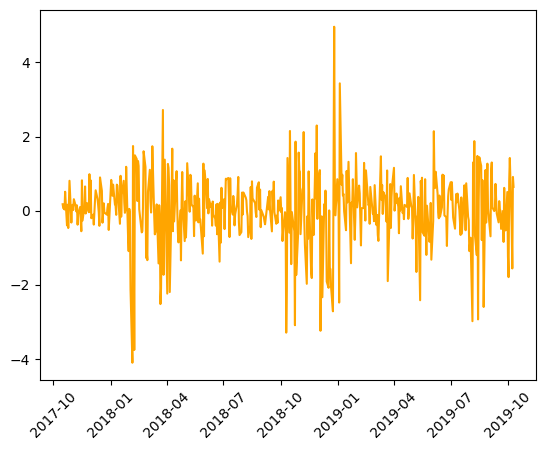

In [7]:
# Plot the price returns
plt.plot(sp_data['Return'], color = 'orange')
plt.xticks(rotation=45)
plt.show()

In [8]:
# Calculate daily std of returns
std_daily = sp_data['Return'].std()
print('Daily volatility: ', '{:.2f}%'.format(std_daily))

Daily volatility:  0.94%


In [9]:
# Convert daily volatility to monthly volatility
std_monthly = math.sqrt(21) * std_daily
print ('Monthly volatility: ', '{:.2f}%'.format(std_monthly))

# Convert daily volatility to annaul volatility
std_annual = math.sqrt(252) * std_daily
print ('Annual volatility: ', '{:.2f}%'.format(std_annual))

Monthly volatility:  4.31%
Annual volatility:  14.92%


Simulate ARCH and GARCH series

In this exercise, you will simulate an ARCH(1) and GARCH(1,1) time series respectively using a predefined function simulate_GARCH(n, omega, alpha, beta = 0).

Recall the difference between an ARCH(1) and a GARCH(1,1) model is: besides an autoregressive component of 
 multiplying lag-1 residual squared, a GARCH model includes a moving average component of 
 multiplying lag-1 variance.

The predefined function will simulate an ARCH/GARCH series based on n (number of simulations), omega, alpha, and beta (0 by default) you specify. It will return simulated residuals and variances. Afterwards you will plot and observe the simulated variances from the ARCH and GARCH process.

In [10]:
def simulate_GARCH(n, omega, alpha, beta = 0):
    np.random.seed(4)
    # Initialize the parameters
    white_noise = np.random.normal(size = n)
    resid = np.zeros_like(white_noise)
    variance = np.zeros_like(white_noise)
    
    for t in range(1, n):
        # Simulate the variance (sigma squared)
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        # Simulate the residuals
        resid[t] = np.sqrt(variance[t]) * white_noise[t]    
    
    return resid, variance

In [11]:
# Simulate a ARCH(1) series
arch_resid, arch_variance = simulate_GARCH(n= 200, 
                                           omega = 0.1, alpha = 0.7)

arch_resid.shape, arch_variance.shape

((200,), (200,))

In [12]:
# Simulate a GARCH(1,1) series
garch_resid, garch_variance = simulate_GARCH(n= 200, 
                                             omega = 0.1, alpha = 0.7, 
                                             beta = 0.1)
garch_resid.shape, garch_variance.shape

((200,), (200,))

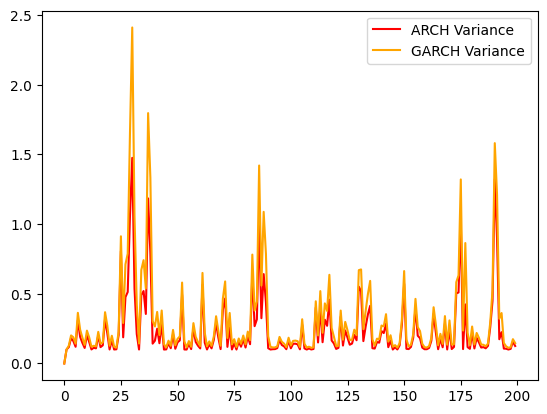

In [13]:
# Plot the ARCH variance
plt.plot(arch_variance, color = 'red', label = 'ARCH Variance')
# Plot the GARCH variance
plt.plot(garch_variance, color = 'orange', label = 'GARCH Variance')
plt.legend()
plt.show()

# overall GARCH model generated higher volatility estimates due to the additional moving average component.

Observe the impact of model parameters

In this exercise, you will call the predefined function simulate_GARCH() again, and study the impact of GARCH model parameters on simulated results.

Specifically, you will simulate two GARCH(1,1) time series, they have the same omega and alpha, but different beta as input.

Recall in GARCH(1,1), since 
 is the coefficient of lag-1 variance, if the 
 is fixed, the larger the 
, the longer the duration of the impact. In other words, high or low volatility periods tend to persist. Pay attention to the plotted results and see whether you can verify the 
 impact.

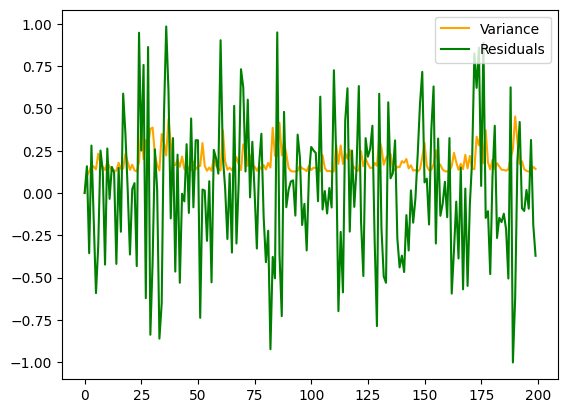

In [14]:
# First simulated GARCH
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, 
                                          alpha = 0.3, beta = 0.2)

plt.plot(sim_variance, color = 'orange', label = 'Variance')
plt.plot(sim_resid, color = 'green', label = 'Residuals')
plt.legend(loc='upper right')
plt.show()

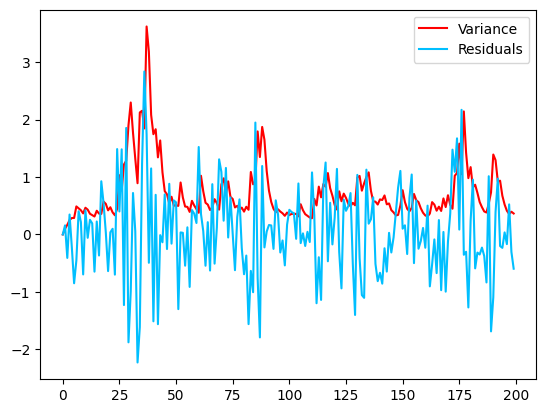

In [15]:
# Second simulated GARCH
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, 
                                          alpha = 0.3, beta = 0.6)
plt.plot(sim_variance, color = 'red', label = 'Variance')
plt.plot(sim_resid, color = 'deepskyblue', label = 'Residuals')
plt.legend(loc='upper right')
plt.show()

# the second simulated GARCH time series has bigger variances in general. The shock that occurred earlier had persistent impact on later data points.

Implement a basic GARCH model

In this exercise, you will get familiar with the Python arch package, and use its functions such as arch_model() to implement a GARCH(1,1) model.

First define a basic GARCH(1,1) model, then fit the model, review the model fitting summary, and plot the results.

In [16]:
# Review "arch" documentation
# The Python arch package provides a comprehensive way to implement GARCH models. Use the code help(arch_model)method to check function documentation of arch_model()

help(arch_model)

Help on function arch_model in module arch.univariate.mean:

arch_model(y: Union[numpy.ndarray, pandas.core.frame.DataFrame, pandas.core.series.Series, NoneType], x: Union[numpy.ndarray, pandas.core.frame.DataFrame, NoneType] = None, mean: Literal['Constant', 'Zero', 'LS', 'AR', 'ARX', 'HAR', 'HARX', 'constant', 'zero'] = 'Constant', lags: Union[int, list[int], numpy.ndarray[Any, numpy.dtype[numpy.intc]], numpy.ndarray[Any, numpy.dtype[numpy.int64]], NoneType] = 0, vol: Literal['GARCH', 'ARCH', 'EGARCH', 'FIGARCH', 'APARCH', 'HARCH'] = 'GARCH', p: Union[int, list[int]] = 1, o: int = 0, q: int = 1, power: float = 2.0, dist: Literal['normal', 'gaussian', 't', 'studentst', 'skewstudent', 'skewt', 'ged', 'generalized error'] = 'normal', hold_back: Optional[int] = None, rescale: Optional[bool] = None) -> arch.univariate.mean.HARX
    Initialization of common ARCH model specifications
    
    Parameters
    ----------
    y : ndarray, Series, None
        The dependent variable
    x : ndar

In [17]:
sp_data = sp_price.dropna() #.loc['2017-10-16':'2019-10-10']
sp_data

,Close,Return
Date,,
2010-07-02,1022.58000000,-0.46623904
2010-07-06,1028.06000000,0.53589939
2010-07-07,1060.27000000,3.13308562
2010-07-08,1070.24000000,0.94032652
2010-07-09,1077.96000000,0.72133353
...,...,...
2019-10-04,2952.01000000,1.42168534
2019-10-07,2938.79000000,-0.44783046
2019-10-08,2893.06000000,-1.55608261


In [18]:
# Specify GARCH model assumptions
basic_gm = arch_model(sp_data['Return'], 
                      p = 1, # indicates how many past residuals (squared) are included in the model.
                      q = 1, # indicates how many past variances are included in the model.
                      mean = 'constant', # the model assumes a constant mean for the time series returns
                      vol = 'GARCH', 
                      dist = 'normal') # the residuals are assumed to follow a normal (Gaussian) distribution.

basic_gm

Constant Mean(constant: yes, no. of exog: 0, volatility: GARCH(p: 1, q: 1), distribution: Normal distribution), id: 0x21fd332f760

In [19]:
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)
gm_result


# the intercept in this model is indeed present and is represented by the constant mean term 𝜇
# this term captures the average return over the period being analyzed. I

Iteration:      4,   Func. Count:     29,   Neg. LLF: 3798.073437458679
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2783.7850577869744
Iteration:     12,   Func. Count:     75,   Neg. LLF: 2770.082165044828
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2770.082165044828
            Iterations: 13
            Function evaluations: 79
            Gradient evaluations: 13


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2770.08
Distribution:                  Normal   AIC:                           5548.16
Method:            Maximum Likelihood   BIC:                           5571.19
                                        No. Observations:                 2335
Date:                Wed, Mar 19 2025   Df Residuals:                     2334
Time:                        19:07:43   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0772  1.444e-02      5.346  8.990e-08 [4.891e-0

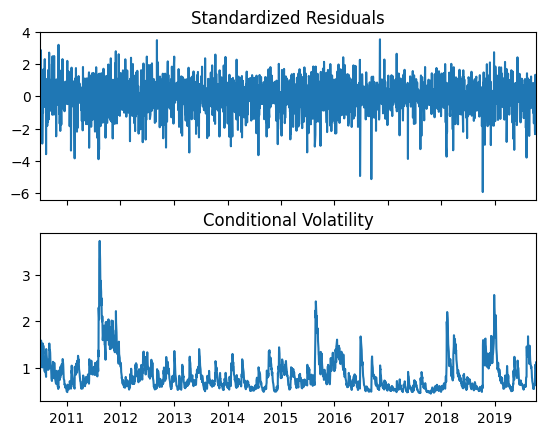

In [20]:
# Plot fitted results
gm_result.plot()
plt.show()

Make forecast with GARCH models

Previously you have implemented a basic GARCH(1,1) model with the Python arch package. In this exercise, you will practice making a basic volatility forecast.

You will again use the historical returns of S&P 500 time series. First define and fit a GARCH(1,1) model with all available observations, then call .forecast() to make a prediction. By default it produces a 1-step ahead estimate. You can use horizon = n to specify longer forward periods.

In [21]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)
gm_forecast

In [22]:
gm_forecast.variance

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-10,0.99406869,0.98827994,0.98275706,0.97748785,0.97246064


Plot distribution of standardized residuals

GARCH models make distribution assumptions of the standardized residuals. The residuals of the model represent the difference between the actual returns and the model's predicted conditional mean (typically zero for most financial return series).
These residuals are essentially the "unexplained" part of the returns after accounting for the mean and volatility dynamics. They capture the unpredictable or "white noise" component.
And standardized residuals are the residuals divided by the model estimated volatility.

In this exercise, you will practice computing the standardized residuals from a fitted GARCH model, and then plot its histogram together with a standard normal distribution normal_resid.

In [23]:
# Calculate residuals manually as returns minus the constant mean (mu)
mu = gm_result.params['mu']
mu

0.0772174357479621

In [24]:
manual_residuals = sp_data['Return'] - mu 
manual_residuals
# here calculated manually, while deriving from the 'resid' attribute afterwards below

Date
2010-07-02   -0.54345647
2010-07-06    0.45868196
2010-07-07    3.05586818
2010-07-08    0.86310908
2010-07-09    0.64411610
                 ...    
2019-10-04    1.34446790
2019-10-07   -0.52504790
2019-10-08   -1.63330004
2019-10-09    0.83323724
2019-10-10    0.56435275
Name: Return, Length: 2335, dtype: float64

In [25]:
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_resid

Date
2010-07-02   -0.54345647
2010-07-06    0.45868196
2010-07-07    3.05586818
2010-07-08    0.86310908
2010-07-09    0.64411610
                 ...    
2019-10-04    1.34446790
2019-10-07   -0.52504790
2019-10-08   -1.63330004
2019-10-09    0.83323724
2019-10-10    0.56435275
Name: resid, Length: 2335, dtype: float64

In [26]:
gm_std = gm_result.conditional_volatility
gm_std

Date
2010-07-02   1.26873751
2010-07-06   1.16339529
2010-07-07   1.06676769
2010-07-08   1.58478919
2010-07-09   1.46201655
                ...    
2019-10-04   1.00548217
2019-10-07   1.06726934
2019-10-08   0.99029881
2019-10-09   1.12278149
2019-10-10   1.07092716
Name: cond_vol, Length: 2335, dtype: float64

In [27]:
# Calculate the standardized residuals
gm_std_resid = gm_resid / gm_std
gm_std_resid

Date
2010-07-02   -0.42834430
2010-07-06    0.39426149
2010-07-07    2.86460512
2010-07-08    0.54462075
2010-07-09    0.44056690
                 ...    
2019-10-04    1.33713749
2019-10-07   -0.49195445
2019-10-08   -1.64930022
2019-10-09    0.74211879
2019-10-10    0.52697585
Length: 2335, dtype: float64

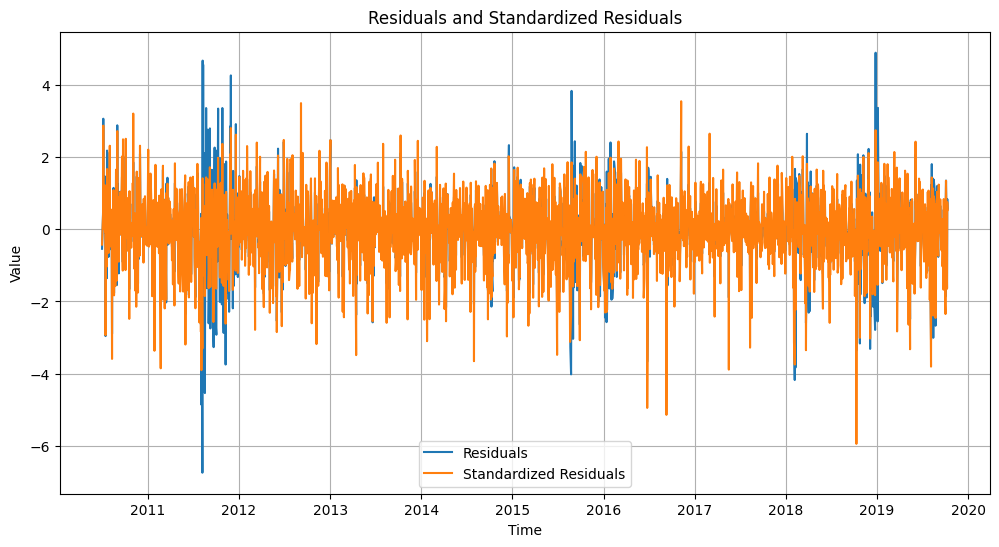

In [28]:
# Plot the residuals
plt.figure(figsize=(12, 6))

# Plot the model residuals
plt.plot(gm_resid, label='Residuals')

# Plot the standardized residuals
plt.plot(gm_std_resid, label='Standardized Residuals')

# Add title and labels
plt.title('Residuals and Standardized Residuals')
plt.xlabel('Time')
plt.ylabel('Value')

# Add a legend
plt.legend()

# Add grid lines
plt.grid(True)

# Show the plot
plt.show()


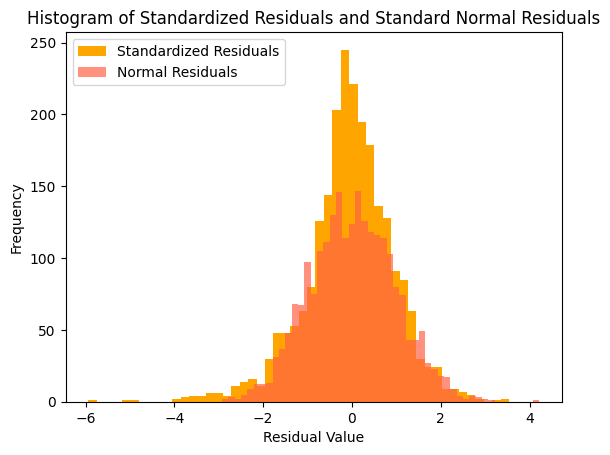

In [29]:
# Number of standard normal residuals to generate (same length as gm_std_resid)
n = len(gm_std_resid)

# Generate standard normal residuals
normal_resid = np.random.normal(loc=0, scale=1, size=n)

# Plot the histogram of the standardized residuals
plt.hist(gm_std_resid, bins=50, facecolor='orange', label='Standardized Residuals')

# Plot the histogram of the standard normal residuals
plt.hist(normal_resid, bins=50, facecolor='tomato', alpha=0.7, label='Normal Residuals')

# Add legend
plt.legend(loc='upper left')

# Add titles and labels
plt.title('Histogram of Standardized Residuals and Standard Normal Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Notice that compared with a standard normal distribution, the distribution curve of standardized residuals from the GARCH models 
# exhibits more peaks, asymmetry, and has a negative skew.

Fit a GARCH with skewed t-distribution

The default normal distribution assumption of the standardized residuals used in GARCH models are not representative of the real financial world. Fat tails and skewness are frequently observed in financial return data.

In this exercise, you will improve the GARCH model by using a skewed Student's t-distribution assumption. In addition, you will compare the model estimated volatility with that from a model with a normal distribution assumption by plotting them together.

In [30]:
normal_vol = gm_std

In [31]:
# Specify GARCH model assumptions
skewt_gm = arch_model(sp_data['Return'], p=1, q=1, mean='constant', vol='GARCH', dist='skewt')

# Fit the model
skewt_result = skewt_gm.fit()

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility
skewt_vol

Iteration:      1,   Func. Count:      8,   Neg. LLF: 87841.44304630479
Iteration:      2,   Func. Count:     19,   Neg. LLF: 165034.84129241406
Iteration:      3,   Func. Count:     28,   Neg. LLF: 13919.893530929236
Iteration:      4,   Func. Count:     36,   Neg. LLF: 5499.372630507622
Iteration:      5,   Func. Count:     44,   Neg. LLF: 4961.97072030221
Iteration:      6,   Func. Count:     52,   Neg. LLF: 2732.0179634238934
Iteration:      7,   Func. Count:     60,   Neg. LLF: 2729.30471802788
Iteration:      8,   Func. Count:     68,   Neg. LLF: 4989.136233666439
Iteration:      9,   Func. Count:     76,   Neg. LLF: 2695.4641232129115
Iteration:     10,   Func. Count:     84,   Neg. LLF: 2701.2979059430045
Iteration:     11,   Func. Count:     92,   Neg. LLF: 2696.1086480530694
Iteration:     12,   Func. Count:    100,   Neg. LLF: 2688.805106009111
Iteration:     13,   Func. Count:    108,   Neg. LLF: 2688.7683062009455
Iteration:     14,   Func. Count:    116,   Neg. LLF: 2688.

Date
2010-07-02   1.28113592
2010-07-06   1.18713904
2010-07-07   1.09980156
2010-07-08   1.60920034
2010-07-09   1.50387904
                ...    
2019-10-04   1.00601058
2019-10-07   1.07589224
2019-10-08   1.00608060
2019-10-09   1.13665119
2019-10-10   1.09390640
Name: cond_vol, Length: 2335, dtype: float64

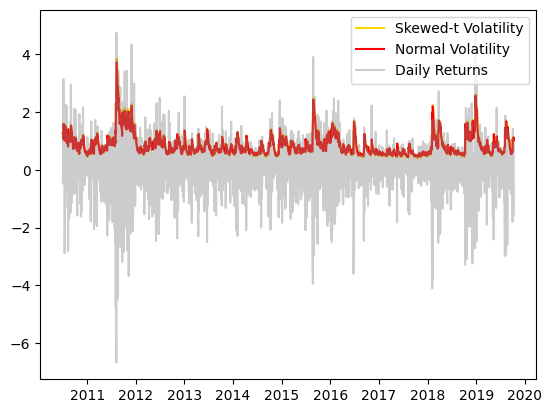

In [32]:
# Plot model fitting results
plt.plot(skewt_vol, color='gold', label='Skewed-t Volatility')  # Corrected line
plt.plot(normal_vol, color='red', label='Normal Volatility')
plt.plot(sp_data['Return'], color='grey', label='Daily Returns', alpha=0.4)
plt.legend(loc='upper right')
plt.show()

# with skewed Student’s t-distribution assumption, GARCH model estimation is more in line with the actual observations.

Effect of mean model on volatility predictions

In practice, returns and volatility are modeled in separate processes. Typically the mean assumptions influence predicted returns, but have a minor effect on the volatility estimations.

In this exercise, you will examine the impact of GARCH model mean assumptions on volatility estimations by comparing two GARCH models. They have been defined with different mean assumptions and fitted with S&P 500 data.

The model with "constant mean" assumption has results saved in cmean_result, and estimated volatility saved in cmean_vol. The model with "AR(1)" or 1-lag autoregressive mean assumption has results saved in armean_result, and estimated volatility saved in armean_vol.

In [33]:
cmean_result = gm_result
cmean_vol = gm_std
cmean_result

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2770.08
Distribution:                  Normal   AIC:                           5548.16
Method:            Maximum Likelihood   BIC:                           5571.19
                                        No. Observations:                 2335
Date:                Wed, Mar 19 2025   Df Residuals:                     2334
Time:                        19:07:43   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0772  1.444e-02      5.346  8.990e-08 [4.891e-0

In [34]:
# Specify GARCH model assumptions
ar_gm = arch_model(sp_data['Return'], 
                      p = 1, # indicates how many past residuals (squared) are included in the model.
                      q = 1, # indicates how many past variances are included in the model.
                      mean = 'AR', # the model assumes a AR mean for the time series returns
                      vol = 'GARCH', 
                      dist = 'normal') # the residuals are assumed to follow a normal (Gaussian) distribution.
ar_gm

AR(constant: yes, lags: none, no. of exog: 0, volatility: GARCH(p: 1, q: 1), distribution: Normal distribution), id: 0x21fd5953a30

In [35]:
armean_result = ar_gm.fit(update_freq = 4)
armean_vol = armean_result.conditional_volatility
armean_result

Iteration:      4,   Func. Count:     29,   Neg. LLF: 3798.073437458679
Iteration:      8,   Func. Count:     53,   Neg. LLF: 2783.7850577869744
Iteration:     12,   Func. Count:     75,   Neg. LLF: 2770.082165044828
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2770.082165044828
            Iterations: 13
            Function evaluations: 79
            Gradient evaluations: 13


                           AR - GARCH Model Results                           
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2770.08
Distribution:                  Normal   AIC:                           5548.16
Method:            Maximum Likelihood   BIC:                           5571.19
                                        No. Observations:                 2335
Date:                Wed, Mar 19 2025   Df Residuals:                     2334
Time:                        19:07:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.0772  1.444e-02      5.346  8.990e-08 [4.891e-0

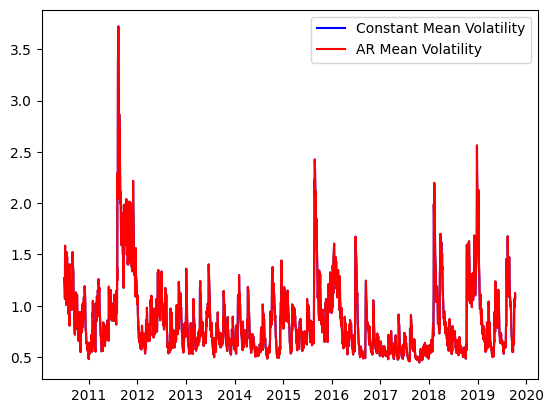

In [36]:
# Plot model volatility 
plt.plot(cmean_vol, color = 'blue', label = 'Constant Mean Volatility')
plt.plot(armean_vol, color = 'red', label = 'AR Mean Volatility')
plt.legend(loc = 'upper right')
plt.show()

In [37]:
# Check correlation of volatility estimations
np.corrcoef(cmean_vol, armean_vol)[0,1]

# The correlation coefficient is close to 1, and the plot shows volatility estimation from both models are very close. 
# In fact, the impact of the mean model assumptions on volatility estimation is so small that, if the interest is only in the volatility dynamics, 
# usually one can just assume the most simple specification, namely the constant mean model.

1.0

Fit GARCH models to cryptocurrency

Financial markets tend to react to positive and negative news shocks very differently, and one example is the dramatic swings observed in the cryptocurrency market in recent years.

In this exercise, you will implement a GJR-GARCH and an EGARCH model respectively in Python, which are popular choices to model the asymmetric responses of volatility. You will work with a cryptocurrency dataset bitcoin_data, which contains two columns: "Close" price and "Return".

In [38]:
bitcoin_data = pd.read_csv('bitcoin.csv', index_col=0)
bitcoin_data.index = pd.to_datetime(bitcoin_data.index)
bitcoin_data

,Close,Return
Date,,
2014-03-27,513.58000000,-8.55382643
2014-03-28,504.00000000,-1.86533744
2014-03-31,465.75000000,-7.58928571
2014-04-01,482.23000000,3.53837896
2014-04-02,429.86000000,-10.85996309
...,...,...
2019-11-27,7550.07000000,6.13705470
2019-11-28,7564.94000000,0.19695182
2019-11-29,7710.34000000,1.92202450


Text(0.5, 1.0, 'Bitcoin closing price evolution')

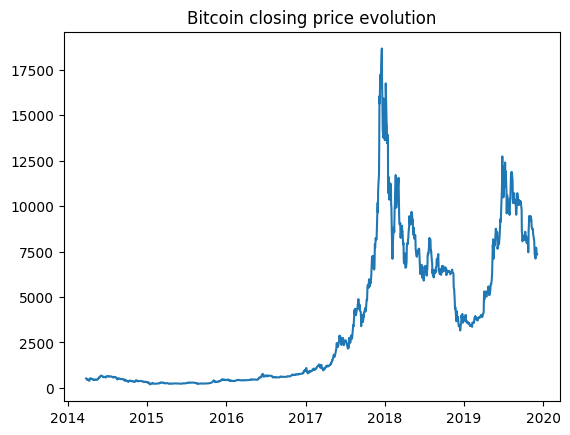

In [39]:
plt.plot(bitcoin_data.Close)
plt.title('Bitcoin closing price evolution')

In [40]:
# Specify model assumptions
gjr_gm = arch_model(bitcoin_data['Return'], p = 1, q = 1, o = 1, vol = 'GARCH', dist = 't')
gjr_gm

Constant Mean(constant: yes, no. of exog: 0, volatility: GJR-GARCH(p: 1, o: 1, q: 1), distribution: Standardized Student's t distribution), id: 0x21fd6ffdbd0

In [41]:
# Fit the model
gjrgm_result = gjr_gm.fit(disp = 'off')

# Print model fitting summary
print(gjrgm_result.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -3966.26
Distribution:      Standardized Student's t   AIC:                           7944.52
Method:                  Maximum Likelihood   BIC:                           7976.33
                                              No. Observations:                 1483
Date:                      Wed, Mar 19 2025   Df Residuals:                     1482
Time:                              19:07:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [42]:
# Specify model assumptions
egarch_gm = arch_model(bitcoin_data['Return'], p = 1, q = 1, o = 1, vol = 'EGARCH', dist = 't')
egarch_gm

Constant Mean(constant: yes, no. of exog: 0, volatility: EGARCH(p: 1, o: 1, q: 1), distribution: Standardized Student's t distribution), id: 0x21fd6ffdba0

In [43]:
# Fit the model
egarch_result = egarch_gm.fit(disp = 'off')

# Print model fitting summary
print(egarch_result.summary())

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -3954.19
Distribution:      Standardized Student's t   AIC:                           7920.38
Method:                  Maximum Likelihood   BIC:                           7952.19
                                              No. Observations:                 1483
Date:                      Wed, Mar 19 2025   Df Residuals:                     1482
Time:                              19:07:46   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

Compare GJR-GARCH with EGARCH

Previously you have fitted a GJR-GARCH and EGARCH model with Bitcoin return time series. In this exercise, you will compare the estimated conditional volatility from the two models by plotting their results.

The GJR-GARCH model estimated volatility is saved in gjrgm_vol, and EGARCH model estimated volatility is saved in egarch_vol. You will plot them together with actual Bitcoin return observations, which can be accessed by column ”Return” in bitcoin_data.

In [44]:
gjrgm_vol = gjrgm_result.conditional_volatility
gjrgm_vol

Date
2014-03-27   6.74541028
2014-03-28   7.03587159
2014-03-31   6.63574461
2014-04-01   6.80003337
2014-04-02   6.49095228
                ...    
2019-11-27   3.42630686
2019-11-28   3.88918158
2019-11-29   3.67366556
2019-12-02   3.53116225
2019-12-03   3.82032480
Name: cond_vol, Length: 1483, dtype: float64

In [45]:
egarch_vol = egarch_result.conditional_volatility
egarch_vol

Date
2014-03-27   7.21693192
2014-03-28   8.37702756
2014-03-31   7.90146400
2014-04-01   8.72572444
2014-04-02   8.53886375
                ...    
2019-11-27   5.15710754
2019-11-28   6.08693560
2019-11-29   5.49951129
2019-12-02   5.35050752
2019-12-03   5.95149443
Name: cond_vol, Length: 1483, dtype: float64

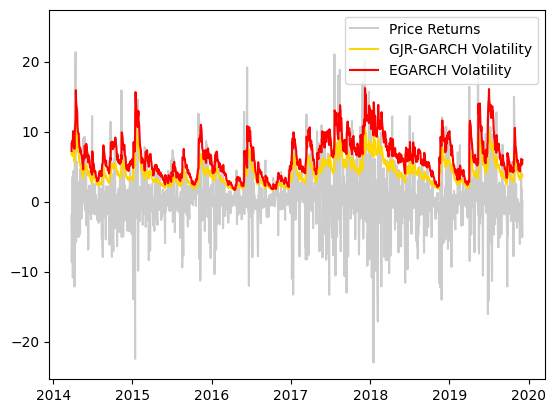

In [46]:
# Plot the actual Bitcoin returns
plt.plot(bitcoin_data['Return'], color = 'grey', alpha = 0.4, label = 'Price Returns')

# Plot GJR-GARCH estimated volatility
plt.plot(gjrgm_vol, color = 'gold', label = 'GJR-GARCH Volatility')

# Plot EGARCH  estimated volatility
plt.plot(egarch_vol, color = 'red', label = 'EGARCH Volatility')

plt.legend(loc = 'upper right')
plt.show()

# GJR-GARCH is more conservative in volatility estimation when applying it to the Bitcoin dataset.

Fixed rolling window forecast

Rolling-window forecasts are very popular for financial time series modeling. In this exercise, you will practice how to implement GARCH model forecasts with a fixed rolling window.

First define the window size inside .fit(), and perform the forecast with a for-loop. Note since the window size remains fixed, both the start and end points increment after each iteration.

The S&P 500 return series has been preloaded as sp_data, and a GARCH(1,1) model has been predefined in basic_gm. The start and end points of the initial sample window has been pre-defined in start_loc and end_loc respectively.

In [47]:
len(sp_data['Return'])

2335

In [48]:
# using a fixed window

start_loc = 2081
end_loc = 2201
total_windows = 35 
forecasts = pd.DataFrame()
                           
for i in range(total_windows):
    time_window_data = sp_data['Return'].iloc[i + start_loc : i + end_loc]

    # Create and fit the model using the specific time window
    ar_gm = arch_model(time_window_data, p=1, q=1, mean='constant', vol='GARCH', dist='normal')
    print('training the model in the time window:', time_window_data.index[0], time_window_data.index[-2])
    gm_result = ar_gm.fit(update_freq=5)
    
    # Conduct 1-period variance forecast and save the result
    fcast = gm_result.forecast(horizon=1).variance
    print('forecasting for the day:', fcast.index.date)
    forecasts = pd.concat([forecasts, fcast])

training the model in the time window: 2018-10-08 00:00:00 2019-03-29 00:00:00
Iteration:      5,   Func. Count:     34,   Neg. LLF: 187.1548086072125
Optimization terminated successfully    (Exit mode 0)
            Current function value: 187.13103443453736
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
forecasting for the day: [datetime.date(2019, 4, 1)]
training the model in the time window: 2018-10-09 00:00:00 2019-04-01 00:00:00
Iteration:      5,   Func. Count:     34,   Neg. LLF: 186.1081136674332
Optimization terminated successfully    (Exit mode 0)
            Current function value: 186.10299134072187
            Iterations: 9
            Function evaluations: 53
            Gradient evaluations: 9
forecasting for the day: [datetime.date(2019, 4, 2)]
training the model in the time window: 2018-10-10 00:00:00 2019-04-02 00:00:00
Iteration:      5,   Func. Count:     35,   Neg. LLF: 279.4511949645845
Iteration:     10,   Func

In [49]:
variance_fixedwin = forecasts
variance_fixedwin

,h.1
Date,
2019-04-01,0.72380677
2019-04-02,0.63240480
2019-04-03,0.55047349
2019-04-04,0.48576984
2019-04-05,0.44316336
2019-04-08,0.38361603
2019-04-09,0.42377770
2019-04-10,0.38409139
2019-04-11,0.32574204


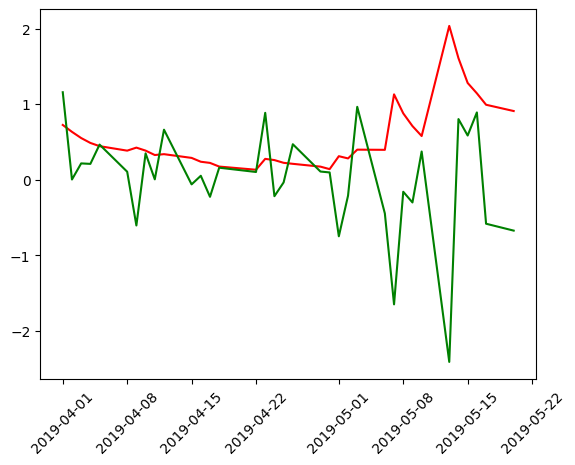

In [50]:
# Plot the forecast variance
plt.plot(forecasts, color = 'red')
plt.plot(time_window_data[forecasts.index], color = 'green')
plt.xticks(rotation=45)
plt.show()

In [51]:
# using an expanding window

start_loc = 2081
end_loc = 2201
total_windows = 35 
forecasts = pd.DataFrame()
                           
for i in range(total_windows):
    time_window_data = sp_data['Return'].iloc[start_loc : i + end_loc]

    # Create and fit the model using the specific time window
    ar_gm = arch_model(time_window_data, p=1, q=1, mean='constant', vol='GARCH', dist='normal')
    print('training the model in the time window:', time_window_data.index[0], time_window_data.index[-2])
    gm_result = ar_gm.fit(update_freq=5)
    
    # Conduct 1-period variance forecast and save the result
    fcast = gm_result.forecast(horizon=1).variance
    print('forecasting for the day:', fcast.index.date)
    forecasts = pd.concat([forecasts, fcast])

training the model in the time window: 2018-10-08 00:00:00 2019-03-29 00:00:00
Iteration:      5,   Func. Count:     34,   Neg. LLF: 187.1548086072125
Optimization terminated successfully    (Exit mode 0)
            Current function value: 187.13103443453736
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
forecasting for the day: [datetime.date(2019, 4, 1)]
training the model in the time window: 2018-10-08 00:00:00 2019-04-01 00:00:00
Iteration:      5,   Func. Count:     34,   Neg. LLF: 187.91111149006386
Optimization terminated successfully    (Exit mode 0)
            Current function value: 187.89017002232563
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 9
forecasting for the day: [datetime.date(2019, 4, 2)]
training the model in the time window: 2018-10-08 00:00:00 2019-04-02 00:00:00
Iteration:      5,   Func. Count:     34,   Neg. LLF: 188.6421000454563
Iteration:     10,   Fun

In [52]:
variance_expandwin = forecasts
variance_expandwin

,h.1
Date,
2019-04-01,0.72380677
2019-04-02,0.63457865
2019-04-03,0.55953910
2019-04-04,0.49406690
2019-04-05,0.45229987
2019-04-08,0.39588795
2019-04-09,0.42855752
2019-04-10,0.38500621
2019-04-11,0.33713753


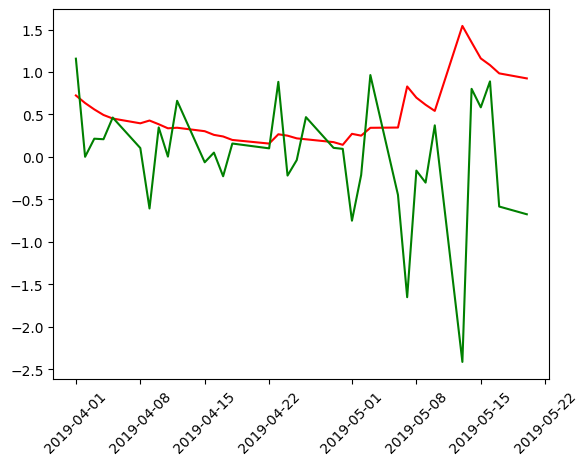

In [53]:
# Plot the forecast variance
plt.plot(forecasts, color = 'red')
plt.plot(time_window_data[forecasts.index], color = 'green')
plt.xticks(rotation=45)
plt.show()

In [54]:
# now forecast variance on bitcoin data for a 120 days time window

start_training = dt.datetime(2018, 9, 1)
end_training =  dt.datetime(2019, 4, 1)
total_windows = 160

bitcoin_data.loc[start_training : start_training + pd.Timedelta(days=1)].Return

Series([], Name: Return, dtype: float64)

In [55]:
# using a fixed window
forecasts = pd.DataFrame()
           
for i in range(total_windows):
    time_window_data = bitcoin_data.loc[start_training + pd.Timedelta(days=i): end_training + pd.Timedelta(days=i)].Return

    # Create and fit the model using the specific time window
    ar_gm = arch_model(time_window_data, p=1, q=1, mean='constant', vol='GARCH', dist='normal')
    print('training the model in the time window:', time_window_data.index[0], time_window_data.index[-2])
    gm_result = ar_gm.fit(update_freq=5, disp=0)
    
    # Conduct 1-period variance forecast and save the result
    fcast = gm_result.forecast(horizon=1).variance
    print('forecasting for the day:', fcast.index.date)
    forecasts = pd.concat([forecasts, fcast])

training the model in the time window: 2018-09-03 00:00:00 2019-03-29 00:00:00
forecasting for the day: [datetime.date(2019, 4, 1)]
training the model in the time window: 2018-09-03 00:00:00 2019-04-01 00:00:00
forecasting for the day: [datetime.date(2019, 4, 2)]
training the model in the time window: 2018-09-03 00:00:00 2019-04-02 00:00:00
forecasting for the day: [datetime.date(2019, 4, 3)]
training the model in the time window: 2018-09-04 00:00:00 2019-04-03 00:00:00
forecasting for the day: [datetime.date(2019, 4, 4)]
training the model in the time window: 2018-09-05 00:00:00 2019-04-04 00:00:00
forecasting for the day: [datetime.date(2019, 4, 5)]
training the model in the time window: 2018-09-06 00:00:00 2019-04-04 00:00:00
forecasting for the day: [datetime.date(2019, 4, 5)]
training the model in the time window: 2018-09-07 00:00:00 2019-04-04 00:00:00
forecasting for the day: [datetime.date(2019, 4, 5)]
training the model in the time window: 2018-09-10 00:00:00 2019-04-05 00:00:

In [56]:
vol_fixedwin_bitcoin = np.sqrt(forecasts)
vol_fixedwin_bitcoin

,h.1
Date,
2019-04-01,2.43962646
2019-04-02,6.13892760
2019-04-03,6.86123631
2019-04-04,6.88954331
2019-04-05,6.17655121
...,...
2019-09-03,4.65737792
2019-09-04,4.36858020
2019-09-05,4.36056619


In [57]:
# using a expaning window
forecasts = pd.DataFrame()
           
for i in range(total_windows):
    time_window_data = bitcoin_data.loc[start_training: end_training + pd.Timedelta(days=i)].Return

    # Create and fit the model using the specific time window
    ar_gm = arch_model(time_window_data, p=1, q=1, mean='constant', vol='GARCH', dist='normal')
    print('training the model in the time window:', time_window_data.index[0], time_window_data.index[-2])
    gm_result = ar_gm.fit(update_freq=5, disp=0)
    
    # Conduct 1-period variance forecast and save the result
    fcast = gm_result.forecast(horizon=1).variance
    print('forecasting for the day:', fcast.index.date)
    forecasts = pd.concat([forecasts, fcast])

training the model in the time window: 2018-09-03 00:00:00 2019-03-29 00:00:00
forecasting for the day: [datetime.date(2019, 4, 1)]
training the model in the time window: 2018-09-03 00:00:00 2019-04-01 00:00:00
forecasting for the day: [datetime.date(2019, 4, 2)]
training the model in the time window: 2018-09-03 00:00:00 2019-04-02 00:00:00
forecasting for the day: [datetime.date(2019, 4, 3)]
training the model in the time window: 2018-09-03 00:00:00 2019-04-03 00:00:00
forecasting for the day: [datetime.date(2019, 4, 4)]
training the model in the time window: 2018-09-03 00:00:00 2019-04-04 00:00:00
forecasting for the day: [datetime.date(2019, 4, 5)]
training the model in the time window: 2018-09-03 00:00:00 2019-04-04 00:00:00
forecasting for the day: [datetime.date(2019, 4, 5)]
training the model in the time window: 2018-09-03 00:00:00 2019-04-04 00:00:00
forecasting for the day: [datetime.date(2019, 4, 5)]
training the model in the time window: 2018-09-03 00:00:00 2019-04-05 00:00:

In [58]:
vol_expwin_bitcoin = np.sqrt(forecasts)
vol_expwin_bitcoin

,h.1
Date,
2019-04-01,2.43962646
2019-04-02,6.13892760
2019-04-03,6.86123631
2019-04-04,6.88545455
2019-04-05,6.15283861
...,...
2019-09-03,4.62577429
2019-09-04,4.30354538
2019-09-05,4.08463378


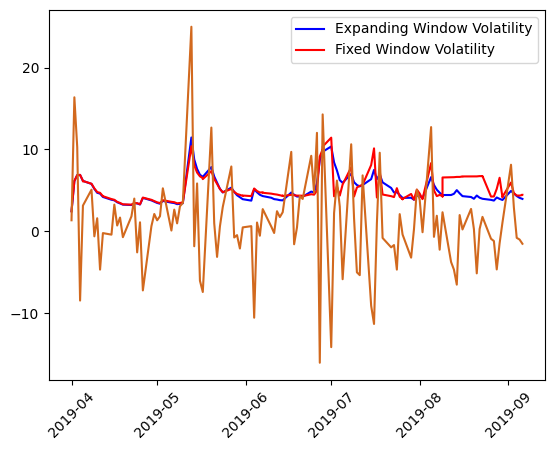

In [59]:
# Plot volatility forecast with an expanding window
plt.plot(vol_expwin_bitcoin, color = 'blue', label='Expanding Window Volatility')
# # Plot volatility forecast with a fixed rolling window
plt.plot(vol_fixedwin_bitcoin, color = 'red', label='Fixed Window Volatility')
plt.plot(time_window_data[forecasts.index], color = 'chocolate')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# By comparison, volatility forecast with a fixed rolling window approach is more responsive to recent return shocks than forecast with an expanding window approach.

Simplify the model with p-values

Leonardo da Vinci once said: "Simplicity is the ultimate sophistication." It also applies to data science modeling. In this exercise, you will practice using the p-values to decide the necessity of model parameters, and define a parsimonious model without insignificant parameters.

The null hypothesis is the parameter value is zero. If the p-value is larger than a given confidence level, the null hypothesis cannot be rejected, meaning the parameter is not statistically significant, hence not necessary.

A GARCH model has been defined and fitted by the Bitcoin return data. The model result is saved in egarch_result.

In [60]:
egarch_result

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -3954.19
Distribution:      Standardized Student's t   AIC:                           7920.38
Method:                  Maximum Likelihood   BIC:                           7952.19
                                              No. Observations:                 1483
Date:                      Wed, Mar 19 2025   Df Residuals:                     1482
Time:                              19:07:46   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [61]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':egarch_result.params,
                             'p-value': egarch_result.pvalues})

# Print out parameter stats
para_summary
# gamma not statistically significant

,parameter,p-value
mu,0.15571313,0.00267028
omega,0.21902144,0.01236120
alpha[1],0.44062168,0.00003242
gamma[1],0.01708653,0.58423198
beta[1],0.97964498,0.00000000
nu,2.33428573,0.00000000


Simplify the model with t-statistics

Besides p-values, t-statistics can also help decide the necessity of model parameters. In this exercise, you will practice using t-statistics to assess the significance of model parameters.

The t-statistic is computed as the estimated parameter value subtracted by its expected mean (zero in this case), and divided by its standard error. The absolute value of the t-statistic is a distance measure, that tells you how many standard errors the estimated parameter is away from 0. As a rule of thumb, if the t-statistic is larger than 2, you can reject the null hypothesis.

In [62]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':egarch_result.params,
                             'std-err': egarch_result.std_err, 
                             't-value': egarch_result.tvalues})

para_summary

,parameter,std-err,t-value
mu,0.15571313,0.05184654,3.00334635
omega,0.21902144,0.08755039,2.50166158
alpha[1],0.44062168,0.10602719,4.15574217
gamma[1],0.01708653,0.03122462,0.54721362
beta[1],0.97964498,0.01076400,91.01123816
nu,2.33428573,0.14350406,16.26633933


In [63]:
# Verify t-statistic by manual calculation
para_summary['calculated_t'] = para_summary['parameter']/para_summary['std-err']

para_summary

# The t-statistics are in agreement with p-values, pointing out that the gamma parameter is not statistically significant and should be left out of the model.

,parameter,std-err,t-value,calculated_t
mu,0.15571313,0.05184654,3.00334635,3.00334635
omega,0.21902144,0.08755039,2.50166158,2.50166158
alpha[1],0.44062168,0.10602719,4.15574217,4.15574217
gamma[1],0.01708653,0.03122462,0.54721362,0.54721362
beta[1],0.97964498,0.01076400,91.01123816,91.01123816
nu,2.33428573,0.14350406,16.26633933,16.26633933


ACF plot

If a GARCH model is doing a good job, the standardized residuals should not exhibit autocorrelations. In this exercise, you will practice using an ACF plot to detect autocorrelations in the data.

The coefficient of correlation between two values in a time series is called the autocorrelation function (ACF), and an ACF plot is a visual representation of correlations between different lags. There are pre-defined functions in Python statsmodels packages that enable you to generate ACF plots easily.

In [64]:
gm_result

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -772.323
Distribution:                  Normal   AIC:                           1552.65
Method:            Maximum Likelihood   BIC:                           1566.97
                                        No. Observations:                  265
Date:                Wed, Mar 19 2025   Df Residuals:                      264
Time:                        19:07:54   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0690      0.265      0.261      0.794 [ -0.450,  0.58

In [65]:
# Extract raw residuals
residuals = gm_result.resid
residuals

Date
2018-09-03    3.53648577
2018-09-04    0.79393551
2018-09-05   -5.67321020
2018-09-06   -7.39073327
2018-09-07    0.03506282
                 ...    
2019-09-02    8.06187644
2019-09-03    2.84777223
2019-09-04   -0.87606767
2019-09-05   -1.08449789
2019-09-06   -1.60175723
Name: resid, Length: 265, dtype: float64

In [66]:
# Extract conditional volatility (this is the standard deviation)
conditional_volatility = gm_result.conditional_volatility
conditional_volatility

Date
2018-09-03   3.54284404
2018-09-04   3.78904902
2018-09-05   3.71721174
2018-09-06   4.25555919
2018-09-07   4.92974067
                ...    
2019-09-02   3.85336962
2019-09-03   4.86224171
2019-09-04   4.59970814
2019-09-05   4.29019417
2019-09-06   4.07649522
Name: cond_vol, Length: 265, dtype: float64

In [67]:
# Calculate standardized residuals
standardized_residuals = residuals / conditional_volatility
standardized_residuals

Date
2018-09-03    0.99820532
2018-09-04    0.20953424
2018-09-05   -1.52620044
2018-09-06   -1.73672435
2018-09-07    0.00711251
                 ...    
2019-09-02    2.09216277
2019-09-03    0.58569121
2019-09-04   -0.19046158
2019-09-05   -0.25278527
2019-09-06   -0.39292508
Length: 265, dtype: float64

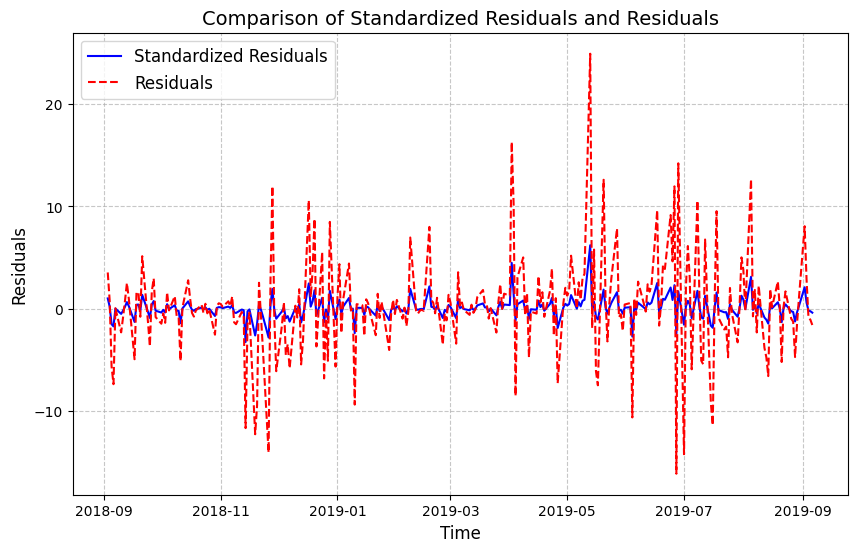

In [68]:
# Create the plot
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(standardized_residuals, label='Standardized Residuals', linestyle='-', color='blue')
plt.plot(residuals, label='Residuals', linestyle='--', color='red')

# Add labels and a title
plt.xlabel('Time', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Comparison of Standardized Residuals and Residuals', fontsize=14)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add a legend
plt.legend(fontsize=12)

# Show the plot
plt.show()


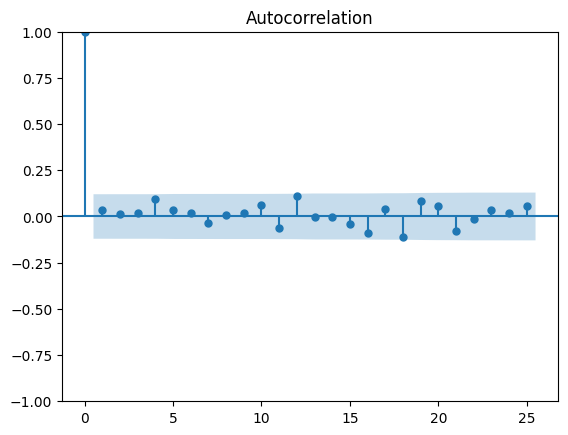

In [69]:
# Generate ACF plot of the standardized residuals
plot_acf(standardized_residuals, alpha = 0.05)
plt.show()

# The ACF plot shows the majority of the data points are within the 5% confidence interval, so the model is doing a decent job

Ljung-Box test

Another powerful tool to check autocorrelations in the data is the Ljung-Box test. In this exercise, you will practice detecting autocorrelation in the standardized residuals by performing a Ljung-Box test.

The null hypothesis of Ljung-Box test is: the data is independently distributed. If the p-value is larger than the specified significance level, the null hypothesis cannot be rejected. In other words, there is no clear sign of autocorrelations and the model is valid.

In [70]:
# Perform the Ljung-Box test
lb_test = acorr_ljungbox(standardized_residuals , lags = 10, return_df = True)
lb_test

# The test is performed up to 10 lags. All the p-values are larger than 5% so the null hypothesis cannot be rejected. 
# In other words, no autocorrelations detected and the model is doing a decent job.

,lb_stat,lb_pvalue
1,0.28621823,0.59265423
2,0.32032642,0.85200472
3,0.40086135,0.94006450
4,2.87393666,0.57913854
5,3.20622706,0.66822597
6,3.31374789,0.76856185
7,3.65779495,0.81824042
8,3.67950024,0.88482113
9,3.78284644,0.92511486
10,4.82746034,0.90240166


In [71]:
normal_result = gm_result
normal_result

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -772.323
Distribution:                  Normal   AIC:                           1552.65
Method:            Maximum Likelihood   BIC:                           1566.97
                                        No. Observations:                  265
Date:                Wed, Mar 19 2025   Df Residuals:                      264
Time:                        19:07:54   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0690      0.265      0.261      0.794 [ -0.450,  0.58

In [72]:
# Specify GARCH model assumptions
skewt_gm = arch_model(sp_data['Return'], 
                      p = 1, # indicates how many past residuals (squared) are included in the model.
                      q = 1, # indicates how many past variances are included in the model.
                      mean = 'constant', # the model assumes a constant mean for the time series returns
                      vol = 'GARCH', 
                      dist = 't') # the residuals assume a skewed t distribution.

skewt_result = skewt_gm.fit(update_freq=5, disp=0)
skewt_result

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2693.31
Distribution:      Standardized Student's t   AIC:                           5396.62
Method:                  Maximum Likelihood   BIC:                           5425.39
                                              No. Observations:                 2335
Date:                      Wed, Mar 19 2025   Df Residuals:                     2334
Time:                              19:07:54   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [73]:
# Print the log-likelihood of normal GARCH
print('Log-likelihood of normal GARCH :', normal_result.loglikelihood)
# Print the log-likelihood of skewt GARCH
print('Log-likelihood of skewt GARCH :', skewt_result.loglikelihood)

# The GARCH model with normal assumption has a higher log-likelihood, hence is relatively better.

Log-likelihood of normal GARCH : -772.3231654906967
Log-likelihood of skewt GARCH : -2693.3075049758595


Pick a winner based on AIC/BIC

In this exercise, you will practice using information criteria to choose a model with the best fit.

Information criteria intend to measure the trade-off between goodness of fit and model complexity. AIC and BIC are two commonly used information criteria for model selection. They both impose penalties on model with more parameters, or more complex models. The lower the AIC or BIC, the better the model.

In [74]:
gjrgm_result

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -3966.26
Distribution:      Standardized Student's t   AIC:                           7944.52
Method:                  Maximum Likelihood   BIC:                           7976.33
                                              No. Observations:                 1483
Date:                      Wed, Mar 19 2025   Df Residuals:                     1482
Time:                              19:07:45   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [75]:
egarch_result

                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                       Return   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -3954.19
Distribution:      Standardized Student's t   AIC:                           7920.38
Method:                  Maximum Likelihood   BIC:                           7952.19
                                              No. Observations:                 1483
Date:                      Wed, Mar 19 2025   Df Residuals:                     1482
Time:                              19:07:46   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu        

In [76]:
# Print the AIC GJR-GARCH
print('AIC of GJR-GARCH model :', gjrgm_result.aic)
# Print the AIC of EGARCH
print('AIC of EGARCH model :', egarch_result.aic)

# Print the BIC GJR-GARCH
print('BIC of GJR-GARCH model :', gjrgm_result.bic)
# Print the BIC of EGARCH
print('BIC of EGARCH model :', egarch_result.bic)

# Both AIC and BIC of the EGARCH model are lower, hence EGARCH is relatively better.

AIC of GJR-GARCH model : 7944.515182772752
AIC of EGARCH model : 7920.376255678416
BIC of GJR-GARCH model : 7976.326116825579
BIC of EGARCH model : 7952.187189731243


In [77]:
bitcoin_data['returns_rescaled'] = bitcoin_data.Close.pct_change()*10
bitcoin_data.dropna(inplace=True)
bitcoin_data

,Close,Return,returns_rescaled
Date,,,
2014-03-28,504.00000000,-1.86533744,-0.18653374
2014-03-31,465.75000000,-7.58928571,-0.75892857
2014-04-01,482.23000000,3.53837896,0.35383790
2014-04-02,429.86000000,-10.85996309,-1.08599631
2014-04-03,436.23000000,1.48187782,0.14818778
...,...,...,...
2019-11-27,7550.07000000,6.13705470,0.61370547
2019-11-28,7564.94000000,0.19695182,0.01969518
2019-11-29,7710.34000000,1.92202450,0.19220245


In [78]:
# forecating variance using a fixed window, and return decimals (not percentages)
start_training = dt.datetime(2019, 1, 1)
end_training =  dt.datetime(2019, 6, 25)
total_windows = 60

forecasts = pd.DataFrame()
           
for i in range(total_windows):
    time_window_data = bitcoin_data.loc[start_training + pd.Timedelta(days=i): end_training + pd.Timedelta(days=i)].returns_rescaled

    # Create and fit the model using the specific time window
    ar_gm = arch_model(time_window_data, p=1, q=1, mean='constant', vol='GARCH', dist='normal')
    print('training the model in the time window:', time_window_data.index[0], time_window_data.index[-2])
    gm_result = ar_gm.fit(update_freq=5, disp=0)
    
    # Conduct 1-period variance forecast and save the result
    fcast = gm_result.forecast(horizon=1).variance
    print('forecasting for the day:', fcast.index.date)
    forecasts = pd.concat([forecasts, fcast])

forecasts

training the model in the time window: 2019-01-01 00:00:00 2019-06-24 00:00:00
forecasting for the day: [datetime.date(2019, 6, 25)]
training the model in the time window: 2019-01-02 00:00:00 2019-06-25 00:00:00
forecasting for the day: [datetime.date(2019, 6, 26)]
training the model in the time window: 2019-01-03 00:00:00 2019-06-26 00:00:00
forecasting for the day: [datetime.date(2019, 6, 27)]
training the model in the time window: 2019-01-04 00:00:00 2019-06-27 00:00:00
forecasting for the day: [datetime.date(2019, 6, 28)]
training the model in the time window: 2019-01-07 00:00:00 2019-06-27 00:00:00
forecasting for the day: [datetime.date(2019, 6, 28)]
training the model in the time window: 2019-01-07 00:00:00 2019-06-27 00:00:00
forecasting for the day: [datetime.date(2019, 6, 28)]
training the model in the time window: 2019-01-07 00:00:00 2019-06-28 00:00:00
forecasting for the day: [datetime.date(2019, 7, 1)]
training the model in the time window: 2019-01-08 00:00:00 2019-07-01 

,h.1
Date,
2019-06-25,0.27042544
2019-06-26,0.28174160
2019-06-27,0.32016938
2019-06-28,2.16032730
2019-06-28,2.16489764
2019-06-28,2.16489764
2019-07-01,2.12363220
2019-07-02,0.17940497
2019-07-03,0.48981852


In [79]:
forecasts['real_variance'] = bitcoin_data['returns_rescaled']**2
forecasts

,h.1,real_variance
Date,,
2019-06-25,0.27042544,0.22028186
2019-06-26,0.28174160,1.44744467
2019-06-27,0.32016938,2.58563731
2019-06-28,2.16032730,2.04073230
2019-06-28,2.16489764,2.04073230
2019-06-28,2.16489764,2.04073230
2019-07-01,2.12363220,2.00858617
2019-07-02,0.17940497,0.04942079
2019-07-03,0.48981852,0.38327531


In [80]:
def evaluate(observation, forecast): 
    # Call sklearn function to calculate MAE
    mae = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(mae))
    # Call sklearn function to calculate MSE
    mse = mean_squared_error(observation, forecast)
    print('Mean Squared Error (MSE): {:.3g}'.format(mse))
    return mae, mse

In [81]:
# Backtest model with MAE, MSE
evaluate(forecasts['h.1'], forecasts['real_variance'])

Mean Absolute Error (MAE): 0.281
Mean Squared Error (MSE): 0.201


(0.28103046341435406, 0.20118181375171532)

Compute parametric and empirical VaR

In this exercise, you will practice estimating dynamic 5% daily VaRs with a parametric and empirical approach.

Recall there are three steps to perform a forward VaR estimation. Step 1 is to use a GARCH model to make variance forecasts. Step 2 is to obtain the GARCH forward-looking mean and volatility. And Step 3 is to compute the quantile according to a given confidence level. The parametric approach estimates quantiles from an assumed distribution assumption.

The difference between parametric VaR and empirical VaR is how the quantiles are estimated. The parametric approach estimates quantiles from an assumed distribution assumption, while the empirical approach estimates quantiles from an observed distribution of the standardized residuals.

In [82]:
# forecating variance using a fixed window, and return decimals (not percentages)
start_training_ix = bitcoin_data.index.get_loc( dt.datetime(2016, 1, 1))
end_training_ix =  bitcoin_data.index.get_loc( dt.datetime(2019, 1, 1))
total_windows = bitcoin_data.shape[0] - end_training_ix

forecasts = pd.DataFrame(columns=['Date', 'Mean', 'Quantile_5%', 'Variance', 'Volatility', 'Residual', 'Standard_Resid', 'Quantile_5%emp'])
           
for i in range(total_windows):
    time_window_data = bitcoin_data.iloc[start_training_ix + i: end_training_ix + i+1].Return

    # Create and fit the model using the specific time window
    ar_gm = arch_model(time_window_data, p=1, q=1, mean='constant', vol='GARCH', dist='t')
    gm_result = ar_gm.fit(update_freq=5, disp=0)
    
    # Conduct 1-period variance forecast and save the result
    variance = gm_result.forecast(horizon=1).variance.iloc[0]['h.1']
    all_volatilities = gm_result.conditional_volatility
    volatility = all_volatilities.iloc[-1]
    all_residuals = gm_result.resid
    residual = all_residuals.iloc[-1]
    std_resid = residual / volatility
    all_std_resid = all_residuals / all_volatilities
    quantile_emp = all_std_resid.quantile(0.05)
    
    # forecasts = pd.concat([forecasts, fcast])
    mean = gm_result.params['mu']
    nu = gm_result.params['nu'] # degrees of freedom
    quantile = ar_gm.distribution.ppf(0.05, nu)

    forecast_date = bitcoin_data.index[end_training_ix + i]

    forecasts.loc[len(forecasts)] = [forecast_date, mean, quantile, variance, volatility, residual, std_resid, quantile_emp]
  
    if i%10 == 0:
        print('training the model in the time window:', time_window_data.index[0], time_window_data.index[-2])
        print('forecasting for the day:', forecast_date)
        

training the model in the time window: 2016-01-01 00:00:00 2018-12-31 00:00:00
forecasting for the day: 2019-01-01 00:00:00
training the model in the time window: 2016-01-15 00:00:00 2019-01-14 00:00:00
forecasting for the day: 2019-01-15 00:00:00
training the model in the time window: 2016-01-29 00:00:00 2019-01-28 00:00:00
forecasting for the day: 2019-01-29 00:00:00
training the model in the time window: 2016-02-12 00:00:00 2019-02-11 00:00:00
forecasting for the day: 2019-02-12 00:00:00
training the model in the time window: 2016-02-26 00:00:00 2019-02-25 00:00:00
forecasting for the day: 2019-02-26 00:00:00
training the model in the time window: 2016-03-11 00:00:00 2019-03-11 00:00:00
forecasting for the day: 2019-03-12 00:00:00
training the model in the time window: 2016-03-25 00:00:00 2019-03-25 00:00:00
forecasting for the day: 2019-03-26 00:00:00
training the model in the time window: 2016-04-08 00:00:00 2019-04-08 00:00:00
forecasting for the day: 2019-04-09 00:00:00
training

In [83]:
bitcoin_data.Return.mean(), gm_result.params['mu'],gm_result.params['nu'] # degrees of freedom

(0.27481542451214575, 0.2743111287448052, 3.0860273320374896)

In [84]:
# Set the 'Date' column as the index
forecasts.set_index('Date', inplace=True)
forecasts['Real_Returns'] = bitcoin_data['Return']
forecasts['Manual_Residuals'] = forecasts['Real_Returns'] - forecasts['Mean']
# forecasts['Manual_Variance'] = forecasts['Volatility']**2


In [85]:
# Calculate the parametric VaR
forecasts['param_VaR_5%'] = forecasts['Mean'] + np.sqrt(forecasts['Variance']) * forecasts['Quantile_5%']

# Calculate the empirical VaR
forecasts['emp_VaR_5%'] = forecasts['Mean'] + np.sqrt(forecasts['Variance']) * forecasts['Quantile_5%emp']
forecasts

,Mean,Quantile_5%,Variance,Volatility,Residual,Standard_Resid,Quantile_5%emp,Real_Returns,Manual_Residuals,param_VaR_5%,emp_VaR_5%
Date,,,,,,,,,,,
2019-01-01,0.24678501,-1.41794379,30.78612107,5.85341385,1.01662614,0.17368089,-1.68333625,1.26341116,1.01662614,-7.62071046,-9.09324693
2019-01-02,0.24881148,-1.42057098,29.42982737,5.54692162,4.16929313,0.75164089,-1.68367254,4.41810461,4.16929313,-7.45768165,-8.88498825
2019-01-03,0.24818217,-1.42193981,27.04764852,5.42332887,-2.56634082,-0.47320398,-1.66660607,-2.31815865,-2.56634082,-7.14695053,-8.41939501
2019-01-04,0.25026738,-1.42174977,24.25540768,5.19853084,0.76714537,0.14756965,-1.66367395,1.01741275,0.76714537,-6.75181888,-7.94329013
2019-01-07,0.25353055,-1.42437530,23.63205651,4.92135197,4.22823952,0.85916219,-1.66459560,4.48177007,4.22823952,-6.67075853,-7.83853700
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-27,0.28462974,-1.38286262,17.32957009,3.83030578,5.85242496,1.52792631,-1.55395122,6.13705470,5.85242496,-5.47206142,-6.18428275
2019-11-28,0.28879769,-1.38056297,15.91879726,4.16910031,-0.09184587,-0.02203014,-1.55344947,0.19695182,-0.09184587,-5.21942318,-5.90921207
2019-11-29,0.29268075,-1.38089389,14.91988674,3.99063555,1.62934375,0.40829179,-1.55414917,1.92202450,1.62934375,-5.04119716,-5.71041767


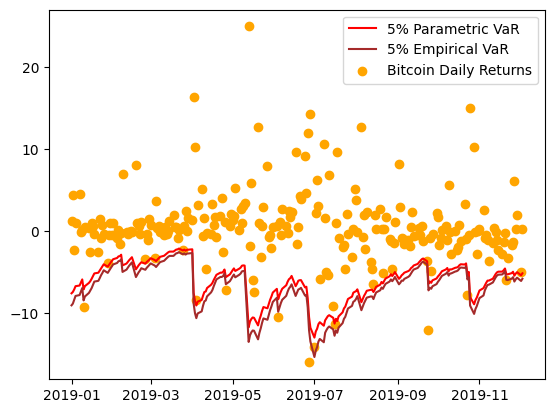

In [86]:
# Plot the VaR
plt.plot(forecasts['param_VaR_5%'], color = 'red', label = '5% Parametric VaR')
plt.plot(forecasts['emp_VaR_5%'], color = 'brown', label = '5% Empirical VaR')
plt.scatter(forecasts.index, forecasts.Real_Returns, color = 'orange', label = 'Bitcoin Daily Returns' )
plt.legend(loc = 'upper right')
plt.show()

# The VaR at 5% represents the potential loss you could experience in the worst 5% of cases (at the lower tail of the distribution) over a specific time period.
# Pay attention to the dots that fell below the VaR threshold. For 5% VaR there are few exceedances observed over 1 year, so the model is doing a decent job.

# Overall both VaRs are very close, but the empirical VaRs have bigger loss estimations, 
# which implies VaRs based on the theoretical Student’s t-distribution assumption may underestimate the downside risks.

Compute GARCH covariance

Covariance describes the relationship of movement between two price return series. Recall dynamic covariance can be computed by ρ * σ1 * σ2, where σ1, σ2 are volatility estimates from GARCH models, and ρ is the simple correlation between GARCH standardized residuals.

In this exercise, you will practice computing dynamic covariance with GARCH models. Specifically you will use two foreign exchange time series data: EUR/USD and USD/CAD (shown in the plot). Their price returns have been fitted by two GARCH models, and the volatility estimates are saved in vol_eur and vol_cad. In addition, their standardized residuals are saved in resid_eur and resid_cad respectively. 

In [87]:
# eur = pd.read_csv('eur.csv')
# eur

In [88]:
api_key = os.getenv('EODHD_API_KEY')
api = APIClient(api_key)

In [89]:
l_e = api.get_list_of_exchanges()
list_exchanges = pd.DataFrame(l_e)
list_exchanges

,Name,Code,OperatingMIC,Country,Currency,CountryISO2,CountryISO3
0,USA Stocks,US,"XNAS, XNYS, OTCM",USA,USD,US,USA
1,London Exchange,LSE,XLON,UK,GBP,GB,GBR
2,Toronto Exchange,TO,XTSE,Canada,CAD,CA,CAN
3,TSX Venture Exchange,V,XTSX,Canada,CAD,CA,CAN
4,NEO Exchange,NEO,NEOE,Canada,CAD,CA,CAN
...,...,...,...,...,...,...,...
73,Money Market Virtual Exchange,MONEY,None,Unknown,Unknown,,
74,Europe Fund Virtual Exchange,EUFUND,None,Unknown,EUR,,
75,Istanbul Stock Exchange,IS,XIST,Turkey,TRY,TR,TUR
76,FOREX,FOREX,CDSL,Unknown,Unknown,,


In [90]:
Code = 'FOREX'

url = f'https://eodhistoricaldata.com/api/exchange-symbol-list/{Code}?api_token={api_key}&fmt=json'
response = requests.get(url)
data = response.json()
[item['Code'] for item in data  if 'USD' in item['Code']][:20]

['AEDUSD',
 'ARSUSD',
 'AUDUSD',
 'BDTUSD',
 'BRLUSD',
 'BWPUSD',
 'BYNUSD',
 'CADUSD',
 'CHFUSD',
 'CLFUSD',
 'CLPUSD',
 'CNHUSD',
 'CNYUSD',
 'COPUSD',
 'CZKUSD',
 'DKKUSD',
 'EGPUSD',
 'EURUSD',
 'FJDUSD',
 'GBPUSD']

In [91]:
EURUSD = pd.DataFrame(api.get_eod_historical_stock_market_data(symbol = 'EURUSD.FOREX', period='d', from_date = '2009-01-00', to_date = '2019-11-25', order='a'))
EURUSD['Return'] = EURUSD.adjusted_close.pct_change()*100
EURUSD.dropna(inplace=True)
EURUSD

,date,open,high,low,close,adjusted_close,volume,Return
1,2009-01-01,1.39640000,1.39990000,1.39460000,1.39910000,1.39910000,0,0.07868383
2,2009-01-02,1.39900000,1.40550000,1.38370000,1.38790000,1.38790000,0,-0.80051462
3,2009-01-05,1.39010000,1.39630000,1.35440000,1.36060000,1.36060000,0,-1.96700050
4,2009-01-06,1.36080000,1.36560000,1.33080000,1.35110000,1.35110000,0,-0.69822137
5,2009-01-07,1.35280000,1.37460000,1.34290000,1.36340000,1.36340000,0,0.91036933
...,...,...,...,...,...,...,...,...
2839,2019-11-19,1.10700000,1.10830000,1.10610000,1.10790000,1.10790000,0,0.06322254
2840,2019-11-20,1.10770000,1.10810000,1.10510000,1.10730000,1.10730000,0,-0.05415651
2841,2019-11-21,1.10720000,1.10960000,1.10500000,1.10590000,1.10590000,0,-0.12643367
2842,2019-11-22,1.10570000,1.10850000,1.10130000,1.10240000,1.10240000,0,-0.31648431


(array([  1.,   1.,   0.,   0.,   5.,   6.,   5.,  10.,  13.,  19.,  14.,
         26.,  38.,  48., 110., 116., 138., 213., 230., 303., 307., 323.,
        255., 187., 129., 107.,  56.,  51.,  45.,  28.,  19.,  12.,  10.,
          6.,   2.,   2.,   4.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([-2.6179997 , -2.48956193, -2.36112417, -2.23268641, -2.10424865,
        -1.97581088, -1.84737312, -1.71893536, -1.5904976 , -1.46205984,
        -1.33362207, -1.20518431, -1.07674655, -0.94830879, -0.81987102,
        -0.69143326, -0.5629955 , -0.43455774, -0.30611997, -0.17768221,
        -0.04924445,  0.07919331,  0.20763107,  0.33606884,  0.4645066 ,
         0.59294436,  0.72138212,  0.84981989,  0.97825765,  1.10669541,
         1.23513317,  1.36357094,  1.4920087 ,  1.62044646,  1.74888422,
         1.87732198,  2.00575975,  2.13419751,  2.26263527,  2.39107303,
         2.5195108 ,  2.64794856,  2.77638632,  2.90482408,  3.03326185,
 

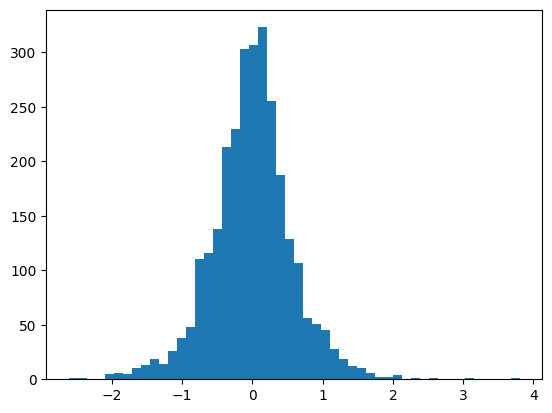

In [92]:
plt.hist(EURUSD.Return, bins=50)

In [93]:
# Create and fit the model using EURUSD.Return
ar_gm = arch_model(EURUSD.Return, p=1, q=1, mean='constant', vol='GARCH', dist='t')
gm_result = ar_gm.fit(update_freq=5, disp=0)

gm_result_mean =  gm_result.params['mu']

EURUSD['Volatility'] = gm_result.conditional_volatility
EURUSD['Residual'] = gm_result.resid
EURUSD['Manual_Residual'] = EURUSD['Return'] - gm_result_mean
EURUSD


,date,open,high,low,close,adjusted_close,volume,Return,Volatility,Residual,Manual_Residual
1,2009-01-01,1.39640000,1.39990000,1.39460000,1.39910000,1.39910000,0,0.07868383,1.06269060,0.08640722,0.08640722
2,2009-01-02,1.39900000,1.40550000,1.38370000,1.38790000,1.38790000,0,-0.80051462,1.04533322,-0.79279123,-0.79279123
3,2009-01-05,1.39010000,1.39630000,1.35440000,1.36060000,1.36060000,0,-1.96700050,1.03770694,-1.95927712,-1.95927712
4,2009-01-06,1.36080000,1.36560000,1.33080000,1.35110000,1.35110000,0,-0.69822137,1.07807755,-0.69049799,-0.69049799
5,2009-01-07,1.35280000,1.37460000,1.34290000,1.36340000,1.36340000,0,0.91036933,1.06738338,0.91809271,0.91809271
...,...,...,...,...,...,...,...,...,...,...,...
2839,2019-11-19,1.10700000,1.10830000,1.10610000,1.10790000,1.10790000,0,0.06322254,0.28906982,0.07094593,0.07094593
2840,2019-11-20,1.10770000,1.10810000,1.10510000,1.10730000,1.10730000,0,-0.05415651,0.28532716,-0.04643313,-0.04643313
2841,2019-11-21,1.10720000,1.10960000,1.10500000,1.10590000,1.10590000,0,-0.12643367,0.28150035,-0.11871028,-0.11871028
2842,2019-11-22,1.10570000,1.10850000,1.10130000,1.10240000,1.10240000,0,-0.31648431,0.27842343,-0.30876093,-0.30876093


In [94]:
USDCAD = pd.DataFrame(api.get_eod_historical_stock_market_data(symbol = 'USDCAD.FOREX', period='d', from_date = '2009-01-00', to_date = '2019-11-25', order='a'))
USDCAD['Return'] = USDCAD.adjusted_close.pct_change()*100
USDCAD.dropna(inplace=True)
USDCAD

,date,open,high,low,close,adjusted_close,volume,Return
1,2009-01-01,1.21670000,1.22230000,1.21640000,1.22070000,1.22070000,0,0.32051282
2,2009-01-02,1.21950000,1.22740000,1.20640000,1.21520000,1.21520000,0,-0.45056115
3,2009-01-05,1.20570000,1.22240000,1.18660000,1.18890000,1.18890000,0,-2.16425280
4,2009-01-06,1.18880000,1.19990000,1.17590000,1.18480000,1.18480000,0,-0.34485659
5,2009-01-07,1.18370000,1.19990000,1.17720000,1.19610000,1.19610000,0,0.95374747
...,...,...,...,...,...,...,...,...
2839,2019-11-19,1.32030000,1.32720000,1.31860000,1.32680000,1.32680000,0,0.46187628
2840,2019-11-20,1.32660000,1.33270000,1.32570000,1.33040000,1.33040000,0,0.27132951
2841,2019-11-21,1.33000000,1.33250000,1.32650000,1.32860000,1.32860000,0,-0.13529765
2842,2019-11-22,1.32840000,1.33020000,1.32500000,1.33020000,1.33020000,0,0.12042752


(array([  3.,   0.,   2.,   5.,   3.,   6.,   2.,  10.,  17.,  15.,  22.,
         30.,  40.,  42.,  95.,  90., 127., 150., 180., 210., 245., 289.,
        236., 228., 199., 139., 112.,  79.,  82.,  29.,  37.,  30.,  21.,
         18.,   9.,   7.,   9.,   4.,   4.,   4.,   3.,   5.,   0.,   1.,
          1.,   1.,   1.,   0.,   0.,   1.]),
 array([-2.1642528 , -2.06310122, -1.96194965, -1.86079807, -1.7596465 ,
        -1.65849492, -1.55734335, -1.45619177, -1.3550402 , -1.25388863,
        -1.15273705, -1.05158548, -0.9504339 , -0.84928233, -0.74813075,
        -0.64697918, -0.5458276 , -0.44467603, -0.34352445, -0.24237288,
        -0.1412213 , -0.04006973,  0.06108185,  0.16223342,  0.263385  ,
         0.36453657,  0.46568814,  0.56683972,  0.66799129,  0.76914287,
         0.87029444,  0.97144602,  1.07259759,  1.17374917,  1.27490074,
         1.37605232,  1.47720389,  1.57835547,  1.67950704,  1.78065862,
         1.88181019,  1.98296177,  2.08411334,  2.18526492,  2.28641649,
 

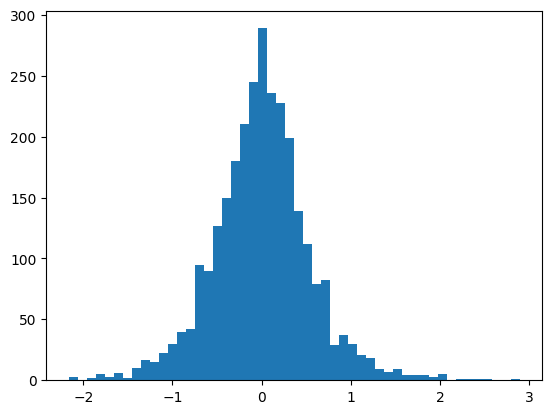

In [95]:
plt.hist(USDCAD.Return, bins=50)

In [96]:
# Create and fit the model using EURUSD.Return
ar_gm = arch_model(USDCAD.Return, p=1, q=1, mean='constant', vol='GARCH', dist='t')
gm_result = ar_gm.fit(update_freq=5, disp=0)

gm_result_mean =  gm_result.params['mu']

USDCAD['Volatility'] = gm_result.conditional_volatility
USDCAD['Residual'] = gm_result.resid
USDCAD['Manual_Residual'] = USDCAD['Return'] - gm_result_mean
USDCAD

,date,open,high,low,close,adjusted_close,volume,Return,Volatility,Residual,Manual_Residual
1,2009-01-01,1.21670000,1.22230000,1.21640000,1.22070000,1.22070000,0,0.32051282,1.08923565,0.31342843,0.31342843
2,2009-01-02,1.21950000,1.22740000,1.20640000,1.21520000,1.21520000,0,-0.45056115,1.06828213,-0.45764555,-0.45764555
3,2009-01-05,1.20570000,1.22240000,1.18660000,1.18890000,1.18890000,0,-2.16425280,1.04982479,-2.17133719,-2.17133719
4,2009-01-06,1.18880000,1.19990000,1.17590000,1.18480000,1.18480000,0,-0.34485659,1.11139041,-0.35194098,-0.35194098
5,2009-01-07,1.18370000,1.19990000,1.17720000,1.19610000,1.19610000,0,0.95374747,1.09036553,0.94666308,0.94666308
...,...,...,...,...,...,...,...,...,...,...,...
2839,2019-11-19,1.32030000,1.32720000,1.31860000,1.32680000,1.32680000,0,0.46187628,0.28047332,0.45479189,0.45479189
2840,2019-11-20,1.32660000,1.33270000,1.32570000,1.33040000,1.33040000,0,0.27132951,0.29023212,0.26424512,0.26424512
2841,2019-11-21,1.33000000,1.33250000,1.32650000,1.32860000,1.32860000,0,-0.13529765,0.29048965,-0.14238205,-0.14238205
2842,2019-11-22,1.32840000,1.33020000,1.32500000,1.33020000,1.33020000,0,0.12042752,0.28749285,0.11334313,0.11334313


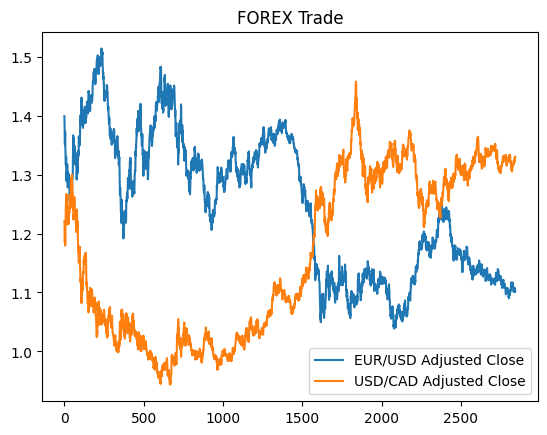

In [97]:
# Plot the data with labels
plt.plot(EURUSD.adjusted_close, label='EUR/USD Adjusted Close')
plt.plot(USDCAD.adjusted_close, label='USD/CAD Adjusted Close')

plt.title('FOREX Trade')

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()


In [98]:
resid_eur = EURUSD['Residual']
vol_eur = EURUSD['Volatility']

resid_cad = USDCAD['Residual']
vol_cad = USDCAD['Volatility']

In [99]:
# Calculate correlation
corr = np.corrcoef(resid_eur, resid_cad)[0,1]
print('Correlation: ', corr)

Correlation:  -0.48042070309328105


In [100]:
# Calculate GARCH covariance
covariance =  corr * vol_eur * vol_cad
covariance

1      -0.55609680
2      -0.53649099
3      -0.52337535
4      -0.57562330
5      -0.55913189
           ...    
2839   -0.03895077
2840   -0.03978417
2841   -0.03928541
2842   -0.03845515
2843   -0.03821727
Name: Volatility, Length: 2843, dtype: float64

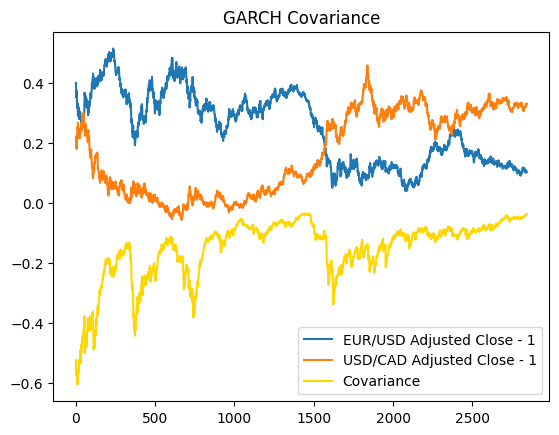

In [101]:
# Plot the data

# Plot the data with labels
plt.plot(EURUSD.adjusted_close - 1, label='EUR/USD Adjusted Close - 1')
plt.plot(USDCAD.adjusted_close - 1, label='USD/CAD Adjusted Close - 1')

plt.plot(covariance, color = 'gold', label='Covariance')
plt.legend()
plt.title('GARCH Covariance')
plt.show()

Compute dynamic portfolio variance

In this exercise, you will practice computing the variance of a simple two-asset portfolio with GARCH dynamic covariance.

The Modern Portfolio Theory states that there is an optimal way to construct a portfolio to take advantage of the diversification effect, so one can obtain a desired level of expected return with the minimum risk. This effect is especially evident when the covariance between asset returns is negative.

Suppose you have a portfolio with only two assets: EUR/USD and CAD/USD currency pairs. Their variance from the GARCH models have been saved in variance_eur and variance_cad, and their covariance has been calculated and saved in covariance. Compute the overall portfolio variances by varying the weights of the two assets, and visualize their differences.

In [102]:
# Define weights
Wa_eur = 0.9
Wa_cad = 1 - Wa_eur

# Calculate portfolio variance
portvar_a = Wa_eur**2 * vol_eur**2 + Wa_cad**2 * vol_cad**2 + 2*Wa_eur*Wa_cad *covariance
portvar_a

1      0.82650908
2      0.79994834
3      0.78905068
4      0.85016317
5      0.83408413
          ...    
2839   0.06146021
2840   0.05962458
2841   0.05795885
2842   0.05669548
2843   0.05743523
Name: Volatility, Length: 2843, dtype: float64

In [103]:
# Define weights
Wb_eur = 0.5
Wb_cad = 1 - Wb_eur

# Calculate portfolio variance
portvar_b = Wb_eur**2 * vol_eur**2 + Wb_cad**2 * vol_cad**2 + 2*Wb_eur*Wb_cad*covariance
portvar_b

1      0.30088800
2      0.29024157
3      0.28305427
4      0.31154832
5      0.30248512
          ...    
2839   0.02108128
2840   0.02151948
2841   0.02126397
2842   0.02081536
2843   0.02067035
Name: Volatility, Length: 2843, dtype: float64

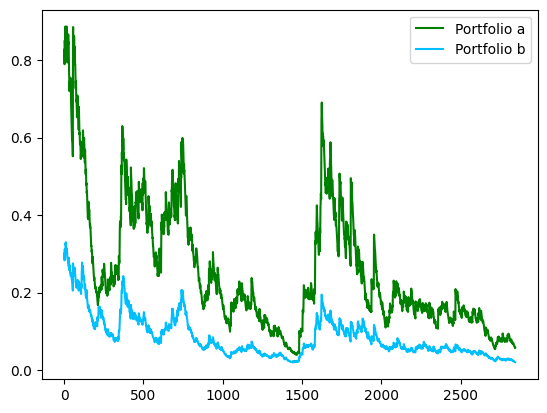

In [104]:
# Plot the data
plt.plot(portvar_a, color = 'green', label = 'Portfolio a')
plt.plot(portvar_b, color = 'deepskyblue', label = 'Portfolio b')
plt.legend(loc = 'upper right')
plt.show()

# Portfolio b is much less volatile compared to portfolio a.

Compute dynamic stock Beta

Suppose you are considering investing in some Tesla stocks. As a shrewd portfolio manager, you decide to do due diligence by checking Tesla stock Beta over the years. Beta is a measure of a stock's volatility in relation to the market, which can serve as a gauge of investment risks.

Recall you need the stock volatility, market (S&P 500 as a proxy) volatility and their return correlation to compute Beta. Correlation can be computed from standardized residuals.

Model fitted volatility has been preloaded for Tesla in teslaGarch_vol, and for S&P 500 in spGarch_vol. In addition, model standardized residuals are preloaded in teslaGarch_resid and spGarch_resid respectively.

,Close,Return
Date,,
2010-07-01,21.96000000,-7.84725136
2010-07-02,19.20000000,-12.56830601
2010-07-06,16.11000000,-16.09375000
2010-07-07,15.80000000,-1.92427064
2010-07-08,17.46000000,10.50632911
...,...,...
2019-10-04,231.43000000,-0.68660687
2019-10-07,237.72000000,2.71788446
2019-10-08,240.05000000,0.98014471


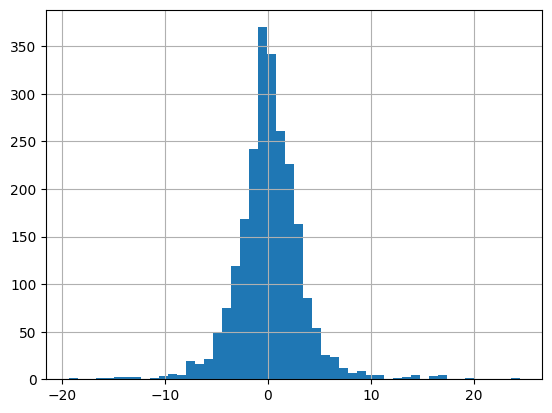

In [105]:
Tesla = pd.read_csv('Tesla.csv', index_col='Date')
Tesla.index = pd.to_datetime(Tesla.index)
Tesla.Return.hist(bins=50)
Tesla

In [106]:
# Create and fit the model 
ar_gm = arch_model(Tesla.Return, p=1, q=1, mean='constant', vol='GARCH', dist='t')
gm_result = ar_gm.fit(update_freq=5, disp=0)

gm_result_mean =  gm_result.params['mu']

Tesla['Volatility'] = gm_result.conditional_volatility
Tesla['Residual'] = gm_result.resid
Tesla['Manual_Residual'] = Tesla['Return'] - gm_result_mean
Tesla['Stand_Residual'] = Tesla['Residual'] / Tesla['Volatility']
Tesla

,Close,Return,Volatility,Residual,Manual_Residual,Stand_Residual
Date,,,,,,
2010-07-01,21.96000000,-7.84725136,6.61240301,-7.96258088,-7.96258088,-1.20418868
2010-07-02,19.20000000,-12.56830601,6.61413244,-12.68363553,-12.68363553,-1.91765672
2010-07-06,16.11000000,-16.09375000,6.85778659,-16.20907952,-16.20907952,-2.36360221
2010-07-07,15.80000000,-1.92427064,7.31750997,-2.03960015,-2.03960015,-0.27872872
2010-07-08,17.46000000,10.50632911,7.14619563,10.39099959,10.39099959,1.45406033
...,...,...,...,...,...,...
2019-10-04,231.43000000,-0.68660687,3.06592711,-0.80193639,-0.80193639,-0.26156408
2019-10-07,237.72000000,2.71788446,3.02262214,2.60255494,2.60255494,0.86102557
2019-10-08,240.05000000,0.98014471,3.01522575,0.86481519,0.86481519,0.28681607


In [107]:
teslaGarch_vol = Tesla['Volatility']
teslaGarch_resid = Tesla['Stand_Residual']

,Close,Return
Date,,
2010-07-01,1027.37000000,-0.32404847
2010-07-02,1022.58000000,-0.46623904
2010-07-06,1028.06000000,0.53589939
2010-07-07,1060.27000000,3.13308562
2010-07-08,1070.24000000,0.94032652
...,...,...
2019-10-04,2952.01000000,1.42168534
2019-10-07,2938.79000000,-0.44783046
2019-10-08,2893.06000000,-1.55608261


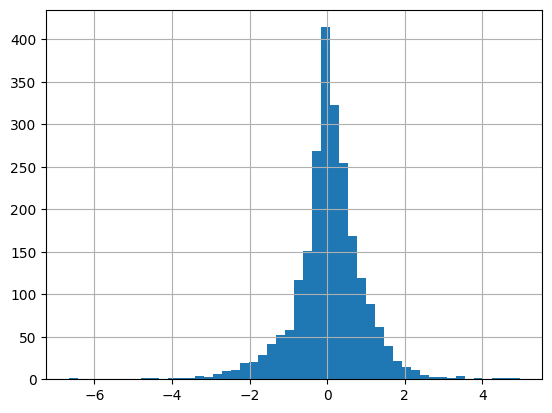

In [108]:
SP500.Return.hist(bins=50)
SP500

In [109]:
# Create and fit the model 
ar_gm = arch_model(SP500.Return, p=1, q=1, mean='constant', vol='GARCH', dist='t')
gm_result = ar_gm.fit(update_freq=5, disp=0)

gm_result_mean =  gm_result.params['mu']

SP500['Volatility'] = gm_result.conditional_volatility
SP500['Residual'] = gm_result.resid
SP500['Manual_Residual'] = SP500['Return'] - gm_result_mean
SP500['Stand_Residual'] = SP500['Residual'] / SP500['Volatility']
SP500

,Close,Return,Volatility,Residual,Manual_Residual,Stand_Residual
Date,,,,,,
2010-07-01,1027.37000000,-0.32404847,1.24844174,-0.40633962,-0.40633962,-0.32547744
2010-07-02,1022.58000000,-0.46623904,1.14947866,-0.54853019,-0.54853019,-0.47719911
2010-07-06,1028.06000000,0.53589939,1.07327677,0.45360824,0.45360824,0.42263865
2010-07-07,1060.27000000,3.13308562,0.99891251,3.05079447,3.05079447,3.05411578
2010-07-08,1070.24000000,0.94032652,1.56404552,0.85803537,0.85803537,0.54860000
...,...,...,...,...,...,...
2019-10-04,2952.01000000,1.42168534,1.02354050,1.33939419,1.33939419,1.30858935
2019-10-07,2938.79000000,-0.44783046,1.08980396,-0.53012161,-0.53012161,-0.48643759
2019-10-08,2893.06000000,-1.55608261,1.01975140,-1.63837375,-1.63837375,-1.60664036


In [110]:
spGarch_vol = SP500['Volatility']
spGarch_resid = SP500['Stand_Residual']

In [111]:
# Compute correlation between SP500 and Tesla
correlation = np.corrcoef(teslaGarch_resid, spGarch_resid)[0, 1]
correlation

0.35923326796795474

In [112]:
# Compute the Beta for Tesla
stock_beta = correlation * (teslaGarch_vol / spGarch_vol)
stock_beta

Date
2010-07-01   1.90268802
2010-07-02   2.06703830
2010-07-06   2.29534931
2010-07-07   2.63155480
2010-07-08   1.64135326
                ...    
2019-10-04   1.07605221
2019-10-07   0.99635023
2019-10-08   1.06218967
2019-10-09   0.92470033
2019-10-10   0.95513277
Name: Volatility, Length: 2336, dtype: float64

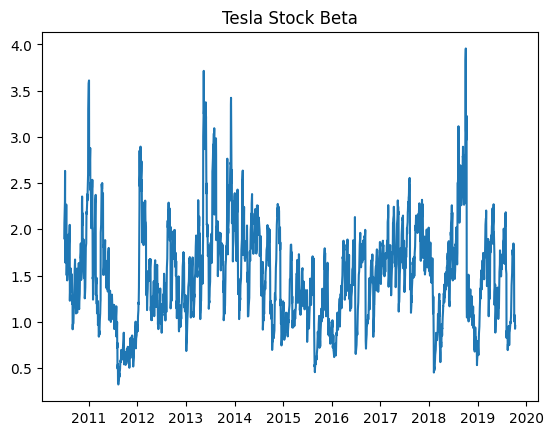

In [113]:
# Plot the Beta
plt.title('Tesla Stock Beta')
plt.plot(stock_beta)
plt.show()